In [1]:
import numpy as np
import csv
import igl
import math
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d 
import plotly.graph_objects as go
import geopandas as gpd
from shapely.geometry import Point, Polygon
import os

In [2]:
# Read the shapefile
current_dir = os.getcwd()
folder_path = os.path.join(current_dir, "ocean")
path = os.path.join(folder_path, "ne_10m_ocean.shp")
ocean = gpd.read_file(path)

#ocean.plot(color='red', edgecolor='black', figsize=(15,15))

In [3]:
# csv file location
current_dir = os.getcwd()
folder_path = os.path.join(current_dir, "Whale")

path = os.path.join(folder_path, "Blue and fin whales Southern California 2014-2015 - Argos data-reference-data.csv")
with open(path, 'r') as file:
    csvreader = csv.reader(file)
    data = []
    for row in csvreader:
        data.append(row)
    data = np.array(data)

# read all csv files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r') as file:
            csvreader = csv.reader(file)
            for row in csvreader:
                # Append the row to the data array, skipping the header row
                if csvreader.line_num > 1:
                    data = np.vstack((data, np.array(row)))

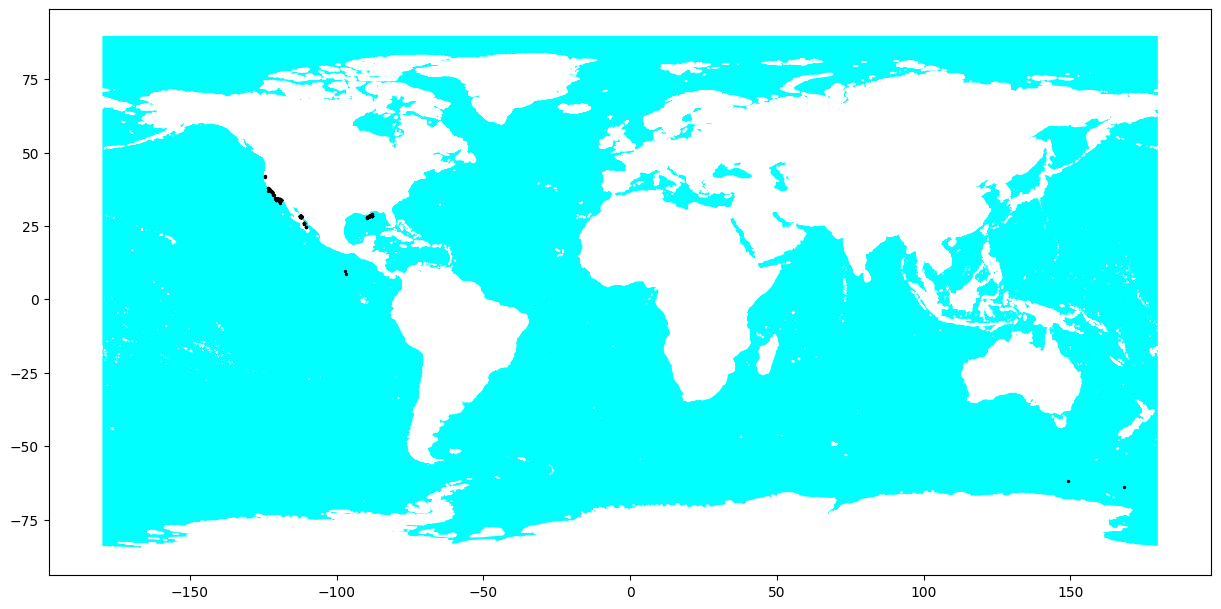

In [14]:
long = data[1:,41]
lat = data[1:,40]
points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(long, lat))

ocean.plot(color='cyan', edgecolor='white', figsize=(15,15))
points.plot(ax=plt.gca(), color='black', markersize=2)
plt.savefig('ocean.png')

In [33]:

point_a = ocean['geometry'].iloc[0]  # First point
point_b = ocean['geometry'].iloc[1]  # Second point

print(point_a)
print(point_b)
a = np.array([-119.0048, 33.9758])
b = np.array([-119.0481, 34.0094])
dst = np.linalg.norm(a - b)
print(dst)
# Calculate the distance between the two points
dist = point_a.distance(point_b)

print(dist)

POINT (-119.0048 33.9758)
POINT (-119.0481 34.0094)
0.054807390012663194
0.054807390012663194


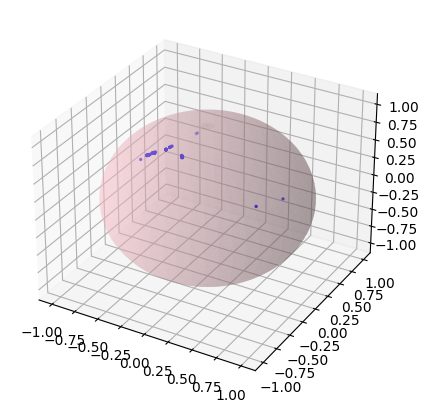

In [5]:
# get the longitude and latitude
long = data[1:,41]
lat = data[1:,40]

# convert to polar coordinates
long = np.array(long, dtype=float)
lat = np.array(lat, dtype=float)

def longConvert(long):
    for i in range(len(long)):
        if long[i] < 0:
            long[i] = 360 + long[i]
    return long

lat = 90 - lat # north pole is 90, south pole is -90, convert to 0 to 180
long = longConvert(long) # convert to 0 to 360

# convert to radians
long = np.deg2rad(long)
lat = np.deg2rad(lat)

# convert to cartesian coordinates
x = np.cos(lat) * np.cos(long)
y = np.cos(lat) * np.sin(long)
z = np.sin(lat)

# Create a sphere
r = 1
u, v = np.mgrid[0:2*np.pi:100j, 0:np.pi:50j]
xs = r*np.cos(u)*np.sin(v)
ys = r*np.sin(u)*np.sin(v)
zs = r*np.cos(v)

# plot
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xs, ys, zs, color='pink', alpha=0.3, label='Sphere')
# ax.set_xlim3d(-1, 1)
# ax.set_ylim3d(-1, 1)
# ax.set_zlim3d(-1, 1)
ax.scatter(x, y, z, s=2, color='b', label='Data')
plt.show()

In [6]:
# distance between two points on a sphere 
# https://www.cuemath.com/trigonometry/trigonometric-table/
# Source: https://www.math.ksu.edu/~dbski/writings/haversine.pdf

def distance(r,vec1,vec2):
    # pythagorean theorem
    # d = math.sqrt((vec2[0]-vec1[0])**2 + (vec2[1]-vec1[1])**2 + (vec2[2]-vec1[2])**2)
    d = np.linalg.norm(vec1-vec2)
    # Arc Distance
    dist = r * 2* math.asin(d/2)
    return dist

def pairDistances(r, data):
    npts = np.shape(data)[0]
    dist = []
    for i in range(npts):
        for j in range(i+1, npts):
            #dist.append(distance(r, data[i, 0], data[i, 1], data[i, 2], data[j, 0], data[j, 1], data[j, 2]))
            dist.append(distance(r, data[i], data[j]))
    return dist

# Calculating the distance between all pairs of points
def surfaceArea(r):
    area = 4 * math.pi * r**2
    return area


def ripleyK(r, data, radii):
    K = np.zeros_like(radii)
    area = surfaceArea(r)
    dist = pairDistances(r, data)
    pair_num = len(dist)
    intensity = pair_num / area
    for i in range(len(radii)):
        K[i] = np.sum(dist < radii[i])
    K = K / intensity
    return K

C:\Users\muhan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 2400 (\N{DEVANAGARI LETTER VOCALIC RR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\muhan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)


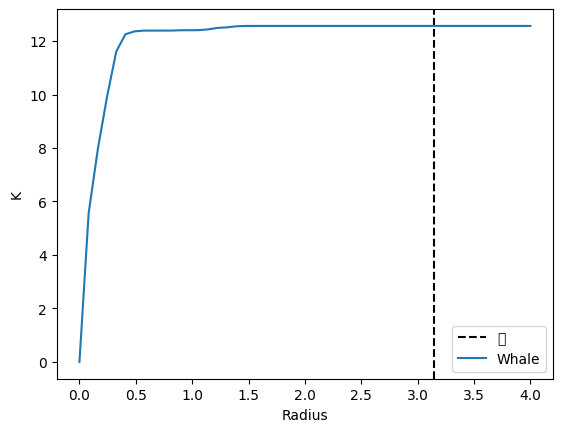

In [7]:
radii = np.linspace(0, 4, 50)
samples_whale = np.vstack((x, y, z)).T

kt_whale = ripleyK(1, samples_whale, radii)
plt.axvline(x=math.pi, color='black', linestyle='--', label=u"\u0960")
plt.plot(radii, kt_whale, label='Whale')
plt.xlabel('Radius')
plt.ylabel('K')
plt.legend()
plt.show()